In [1]:
import pyarrow.parquet as pq

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
df = pd.read_csv('metadata_train.csv')

In [5]:
df['signal_id'].nunique()

8712

In [6]:
df['id_measurement'].nunique()

2904

In [7]:
8712/2904

3.0

In [8]:
df.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [18]:
signals = pq.read_table('train.parquet', columns=[str(i) for i in range(999)]).to_pandas()

In [19]:
signals = np.array(signals).T.reshape((999//3, 3, 800000))


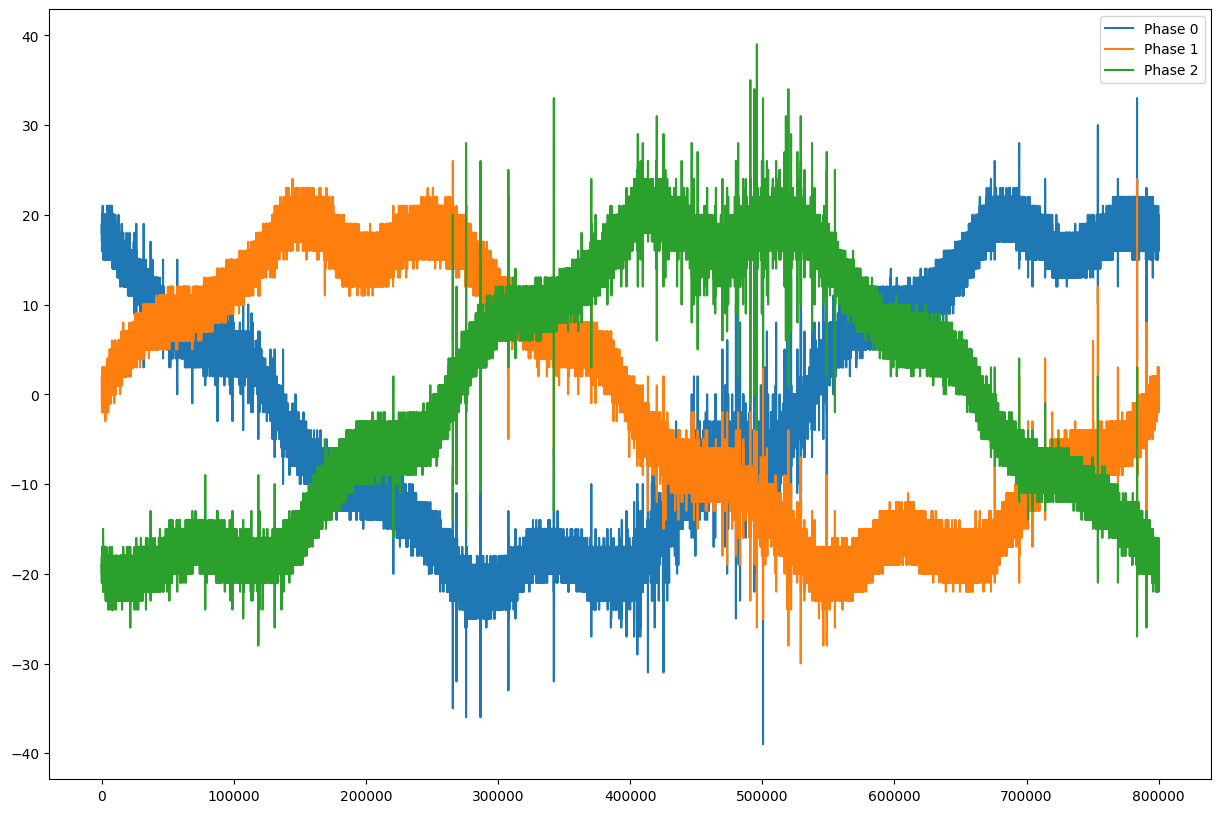

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Phase 0')
plt.plot(signals[0, 1, :], label='Phase 1')
plt.plot(signals[0, 2, :], label='Phase 2')
plt.legend()
plt.show()

In [22]:
df['target'].value_counts()

0    8187
1     525
Name: target, dtype: int64

In [1]:
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [2]:
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    # convert data into -1 to 1
    ts_std = min_max_transf(ts, min_data=min_num, max_data=max_num)
    # bucket or chunk size, 5000 in this case (800000 / 160)
    bucket_size = int(sample_size / n_dim)
    # new_ts will be the container of the new data
    new_ts = []
    # this for iteract any chunk/bucket until reach the whole sample_size (800000)
    for i in range(0, sample_size, bucket_size):
        # cut each bucket to ts_range
        ts_range = ts_std[i:i + bucket_size]
        # calculate each feature
        mean = ts_range.mean()
        std = ts_range.std() # standard deviation
        std_top = mean + std # I have to test it more, but is is like a band
        std_bot = mean - std
        # I think that the percentiles are very important, it is like a distribuiton analysis from eath chunk
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100]) 
        max_range = percentil_calc[-1] - percentil_calc[0] # this is the amplitude of the chunk
        relative_percentile = percentil_calc - mean # maybe it could heap to understand the asymmetry
        # now, we just add all the features to new_ts and convert it to np.array
        new_ts.append(np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]),percentil_calc, relative_percentile]))
    return np.asarray(new_ts)

In [3]:
def prep_data(start, end):
    # load a piece of data from file
    praq_train = pq.read_pandas('../input/train.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    X = []
    y = []
    # using tdqm to evaluate processing time
    # takes each index from df_train and iteract it from start to end
    # it is divided by 3 because for each id_measurement there are 3 id_signal, and the start/end parameters are id_signal
    for id_measurement in tqdm(df_train.index.levels[0].unique()[int(start/3):int(end/3)]):
        X_signal = []
        # for each phase of the signal
        for phase in [0,1,2]:
            # extract from df_train both signal_id and target to compose the new data sets
            signal_id, target = df_train.loc[id_measurement].loc[phase]
            # but just append the target one time, to not triplicate it
            if phase == 0:
                y.append(target)
            # extract and transform data into sets of features
            X_signal.append(transform_ts(praq_train[str(signal_id)]))
        # concatenate all the 3 phases in one matrix
        X_signal = np.concatenate(X_signal, axis=1)
        # add the data to X
        X.append(X_signal)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

In [ ]:
X = []
y = []
def load_all():
    total_size = len(df_train)
    for ini, end in [(0, int(total_size/2)), (int(total_size/2), total_size)]:
        X_temp, y_temp = prep_data(ini, end)
        X.append(X_temp)
        y.append(y_temp)
load_all()
X = np.concatenate(X)
y = np.concatenate(y)